In [52]:
%matplotlib inline
import Euclid
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from astropy.table import Table, join
from astropy import units as u
from astropy.units import photometric
from astropy.coordinates import SkyCoord

In [67]:
plt.rcParams['figure.figsize'] = (20, 10)

## Setup environment

In [38]:
%elogin

In [39]:
%erun Phosphoros

In [40]:
from PhzCLI.PlotSpecZComparison import SpeczPhotozPlot, displayHistogram, compute_stats, boxPlot

## Read the Phosphoros output catalog and MER input

In [97]:
phosphoros_result = Table.read('/home/aalvarez/Phosphoros/Results/SC7_MER_with_SC456_Calib/EUC_MER_FINAL-CAT_8BD1D7_20200424T080307/phz_cat.fits')
mer_table = Table.read('/home/aalvarez/Work/Data/SC7/PerPipeline/PS_DEV_PHZProduction_20200310-VALIDATION-nmorisse-PLAN-0001-2020-04-24-21-48-02-12/EUC_MER_FINAL-CAT_8BD1D7_20200424T080307.090421Z_00.00.fits')

## Read the TU tile

In [98]:
tu_tile = Table.read('/home/aalvarez/Work/Data/SC7/TU/EUC-GALCAT-2020-01-14_HPIX_5_NEST_4208.fits')

## Cross match

In [101]:
pho_coords = SkyCoord(phosphoros_result['RIGHT_ASCENSION'], phosphoros_result['DECLINATION'])
tu_coors = SkyCoord(tu_tile['RA_MAG'] * u.deg, tu_tile['DEC_MAG'] * u.deg)

In [102]:
tu_idx, distances, _ = pho_coords.match_to_catalog_sky(tu_coors)

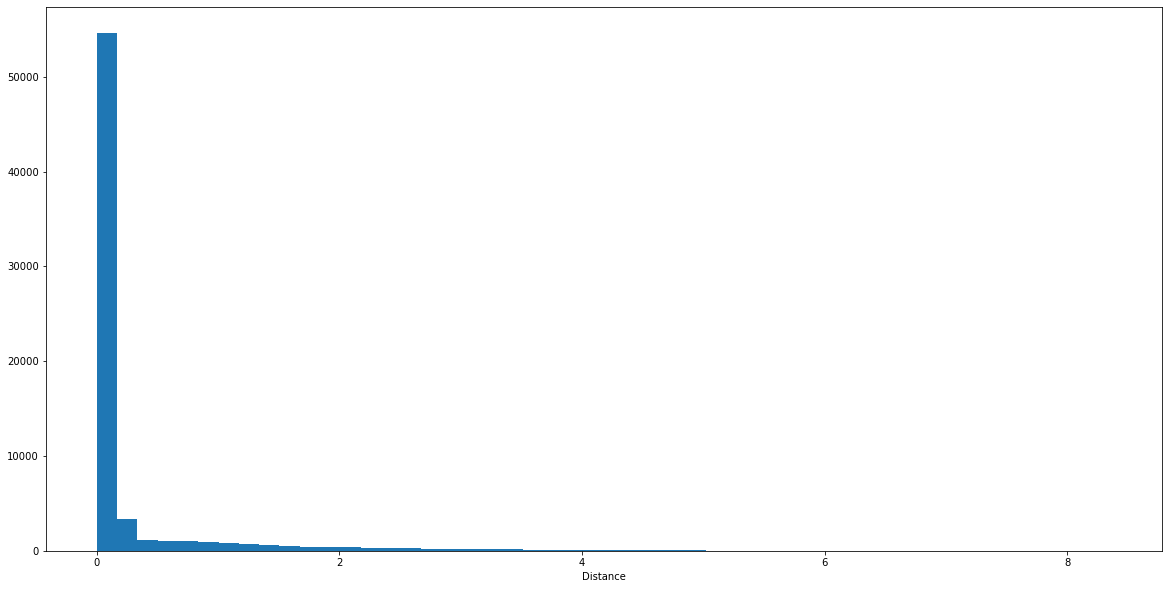

In [103]:
plt.figure()
plt.hist(distances.arcsec, bins=50)
plt.xlabel('Distance')
plt.show()

In [107]:
# Join
phosphoros_result['Z_OBS'] = tu_tile[tu_idx]['Z_OBS']

In [109]:
# Join with mer
phosphoros_result['OBJECT_ID'] = phosphoros_result['ID']
phosphoros_match = join(phosphoros_result, mer_table, 'OBJECT_ID')

## Filter out objects with SNR <= 10

In [110]:
snr = phosphoros_match['FLUX_VIS_APER'] / phosphoros_match['FLUXERR_VIS_APER'] > 10

/home/aalvarez/miniconda3/envs/phz/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


In [111]:
phosphoros_match = phosphoros_match[snr]

In [112]:
len(phosphoros_match)

24168

## Compute Magnitude AB

In [113]:
phosphoros_match['MAG_VIS_AB'] = phosphoros_match['FLUX_VIS_APER'].to(u.mag(photometric.AB))

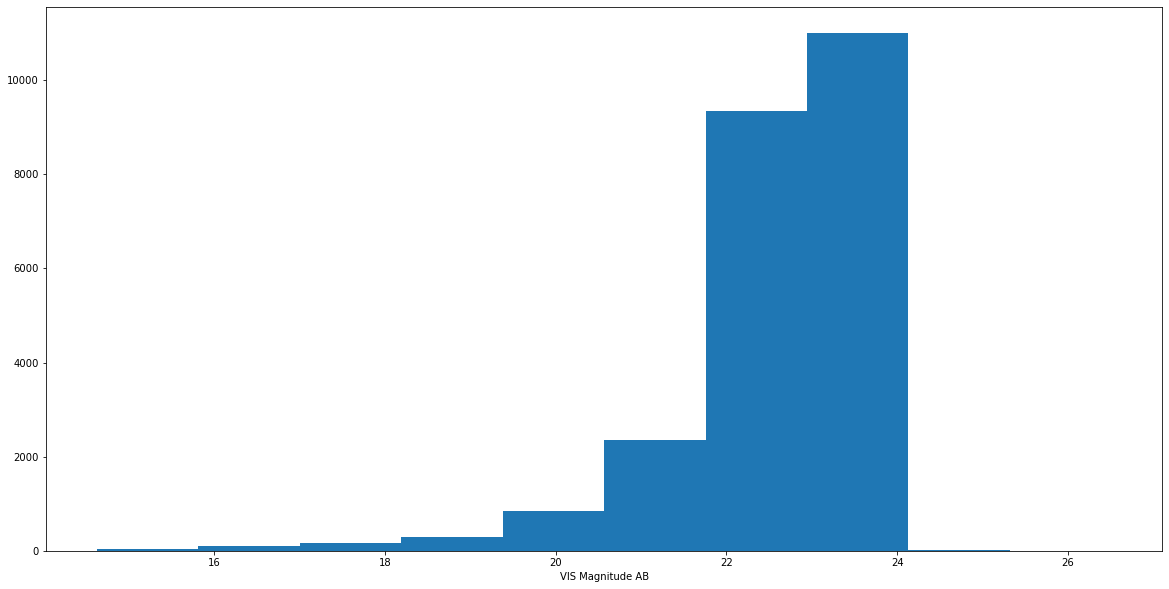

In [114]:
plt.figure()
plt.hist(phosphoros_match['MAG_VIS_AB'])
plt.xlabel('VIS Magnitude AB')
plt.show()

## Apply cut

In [115]:
mag_vis = np.logical_and(phosphoros_match['MAG_VIS_AB'] > 17, phosphoros_match['MAG_VIS_AB'] < 24)

In [116]:
phosphoros_match = phosphoros_match[mag_vis]
len(phosphoros_match)

24009

## Compute statistics

In [117]:
data, mean, median, sigma, mad, outliersPercent,sigmaNoOutliers, meanNoOutliers = compute_stats(phosphoros_match['Z_OBS'], phosphoros_match['Z'])

--> Mean                :  0.18197282631444991
--> Median              :  -0.007764316152426681
--> Sigma               :  0.7016815054847775
--> Mad                 :  0.10808405281620802
--> Outliers            :  42.379940855512515 %
--> Sigma (no outliers) :  0.0400231951636296


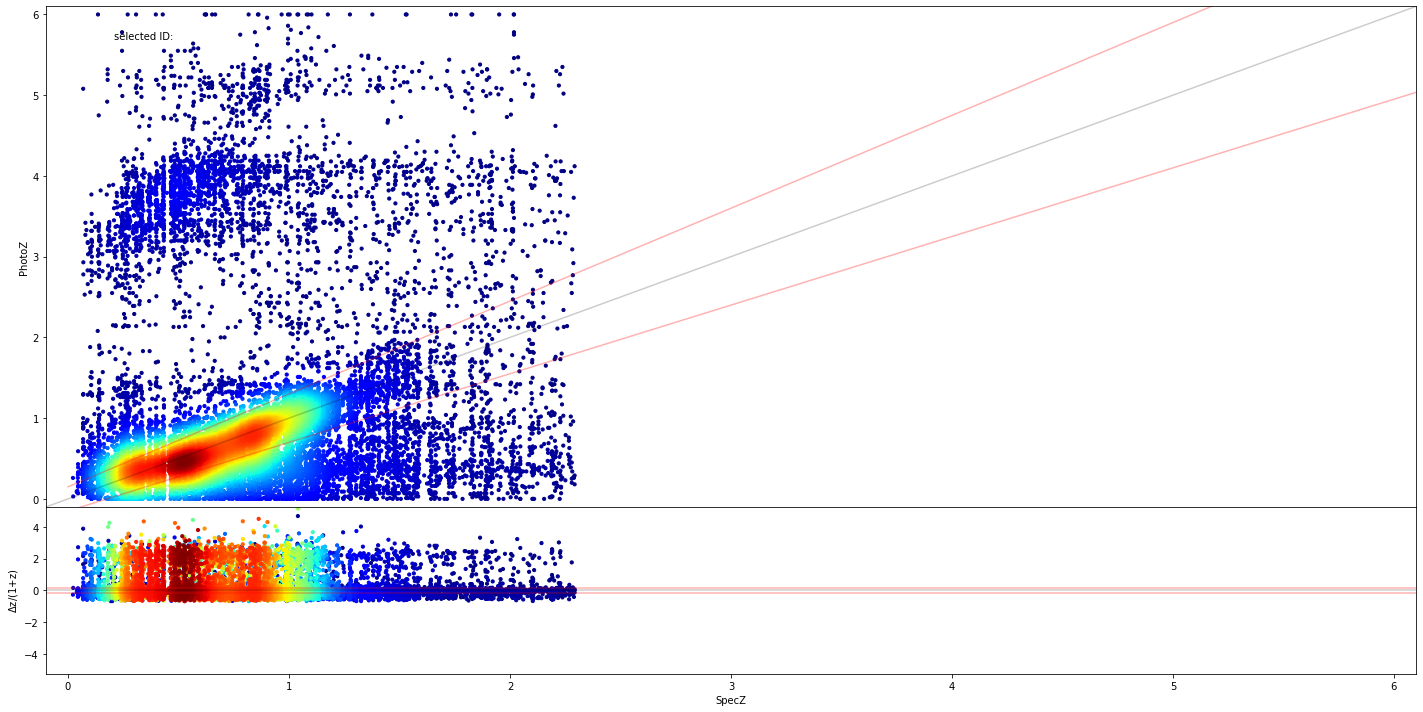

In [118]:
SpeczPhotozPlot(phosphoros_match['OBJECT_ID'], phosphoros_match['Z_OBS'], phosphoros_match['Z'], data)

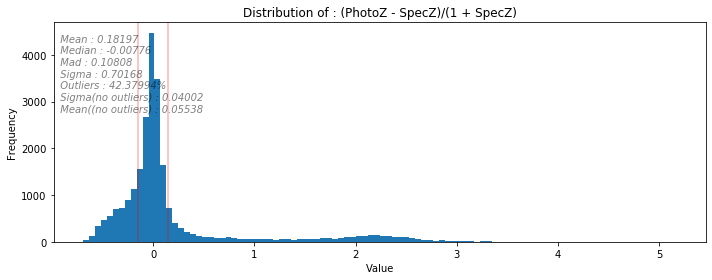

In [119]:
_ = displayHistogram(data, mean, median, mad, sigma, outliersPercent, sigmaNoOutliers, meanNoOutliers)

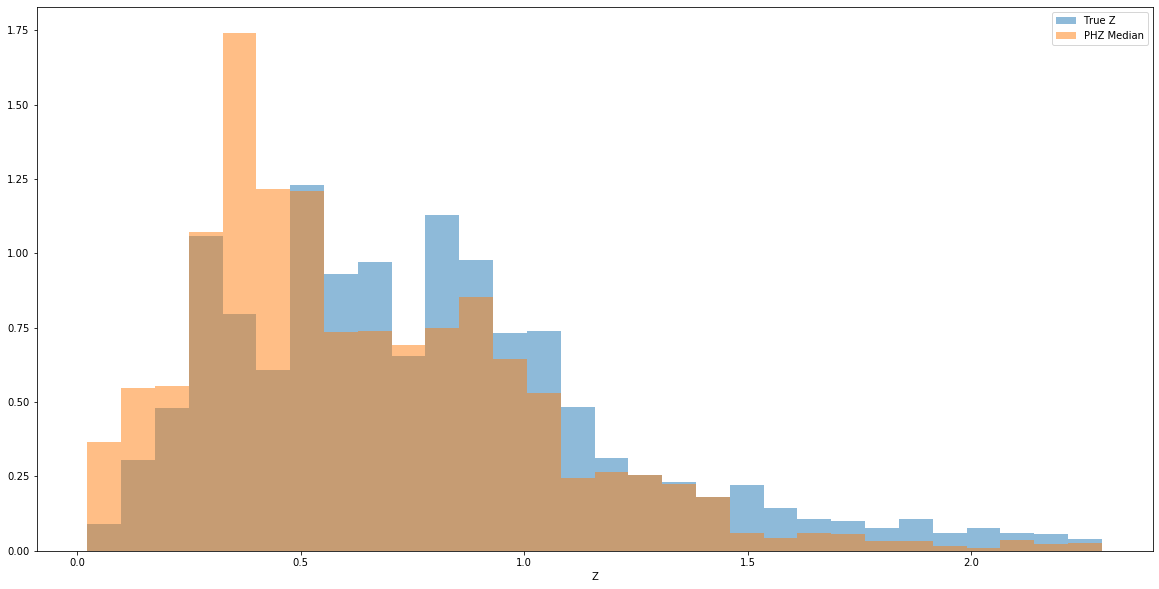

In [127]:
plt.figure()
bins = plt.hist(phosphoros_match['Z_OBS'], bins=30, alpha=0.5, density=True, label='True Z')
plt.hist(phosphoros_match['Z'], bins=bins[1], alpha=0.5, density=True, label='PHZ Median')
plt.xlabel('Z')
plt.legend()
plt.show()

## Box plot

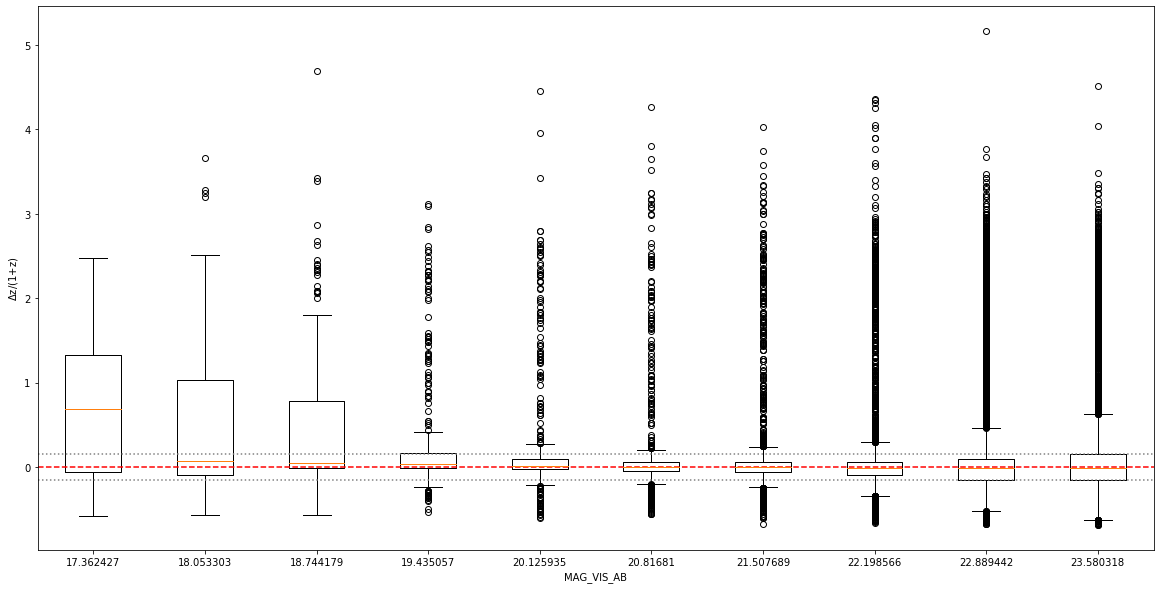

In [121]:
boxPlot(phosphoros_match['MAG_VIS_AB'], data)
plt.show()